<a href="https://colab.research.google.com/github/praneeth2104/inventorymanag_demandforecast/blob/main/inventory_managment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import os
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from prophet import Prophet

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import calendar
import squarify

In [ ]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding="ISO-8859-1")

# data preprocessing

deleting columns

In [ ]:
def drop_columns(df, columns_to_drop):
    try:
        df = df.drop(columns=columns_to_drop)
        print(f"{len(columns_to_drop)} columns dropped successfully. Number of columns remaining: {len(df.columns)}")

        return df

    except KeyError as e:
        # If any column in columns_to_drop is not found in the dataframe
        print(f"""Column(s): {e} not found in dataframe.

            No columns dropped.
            Please Check that the column names are correct.""")
        return df


In [ ]:
columns_to_keep = ['Days for shipping (real)',
                  'Days for shipment (scheduled)',
                  'Customer Country',
                  'Sales per customer',
                  'Delivery Status',
                  'Late_delivery_risk',
                  'Customer City',
                  'Customer Segment',
                  'Sales','Shipping Mode',
                  'Type', 'Product Card Id',
                  'Customer Zipcode',
                  'Product Category Id',
                  'Product Name',
                  'Product Price',
                  'Market',
                  'Product Status',
                  'shipping date (DateOrders)']

In [ ]:
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = drop_columns(df, columns_to_drop)

34 columns dropped successfully. Number of columns remaining: 19


checking for null values

In [ ]:
def check_null_values(df):
    null_values = df.isnull().sum()
    if null_values.sum() == 0:
        print("No null values found ")
    else:
        print("Null values found in the following columns:")
        for column, null_count in null_values.items():
            if null_count > 0:
                print(f"{column}: {null_count}")

In [ ]:
check_null_values(df)

Null values found in the following columns:
Customer Zipcode: 3


new columns for better analysis

In [ ]:
df['Lead Time'] = df['Days for shipping (real)'] - df['Days for shipment (scheduled)']


In [ ]:
def extract_date_parts(df, date_column, prefix):

    try:
        df[date_column] = pd.to_datetime(df[date_column])
        df[f'{prefix} Year'] = df[date_column].dt.year
        df[f'{prefix} Month'] = df[date_column].dt.month
        df[f'{prefix} Day'] = df[date_column].dt.day
        df[f'{prefix} Weekday'] = df[date_column].dt.weekday
        print(f"success")
        return df
    except Exception as e:
        print(f"Error creating columns: {e}")
        return df


In [ ]:
df = extract_date_parts(df, 'shipping date (DateOrders)', 'Shipping')



success


label encoding and one hot encoder

In [ ]:
top_product = df['Product Card Id'].value_counts().index[0]

In [ ]:
df_copy = df[df['Product Card Id'] == top_product].copy()

In [ ]:
categorical_cols = ['Type', 'Customer Segment',
                    'Delivery Status',
                    'Customer City',
                    'Market',
                    'Shipping Mode']
columns_to_drop = ['Product Name',
                   'Days for shipment (scheduled)',
                   'Sales per customer',
                   'Days for shipping (real)',
                   'Customer Country',
                   'shipping date (DateOrders)',
                   'Product Card Id',
                   'Product Category Id',
                   'Product Status',
                   'Product Price']

In [ ]:
label_encoder = LabelEncoder()
df_label_encoded = df_copy.copy()
for col in categorical_cols:
    df_label_encoded[col] = label_encoder.fit_transform(df_label_encoded[col])
df_label_encoded = df_label_encoded.drop(columns=columns_to_drop)


In [ ]:
df_one_hot_encoded = pd.get_dummies(df_copy, columns=categorical_cols)
df_one_hot_encoded = df_one_hot_encoded.drop(columns=columns_to_drop)

# data visualization

univariate analysis

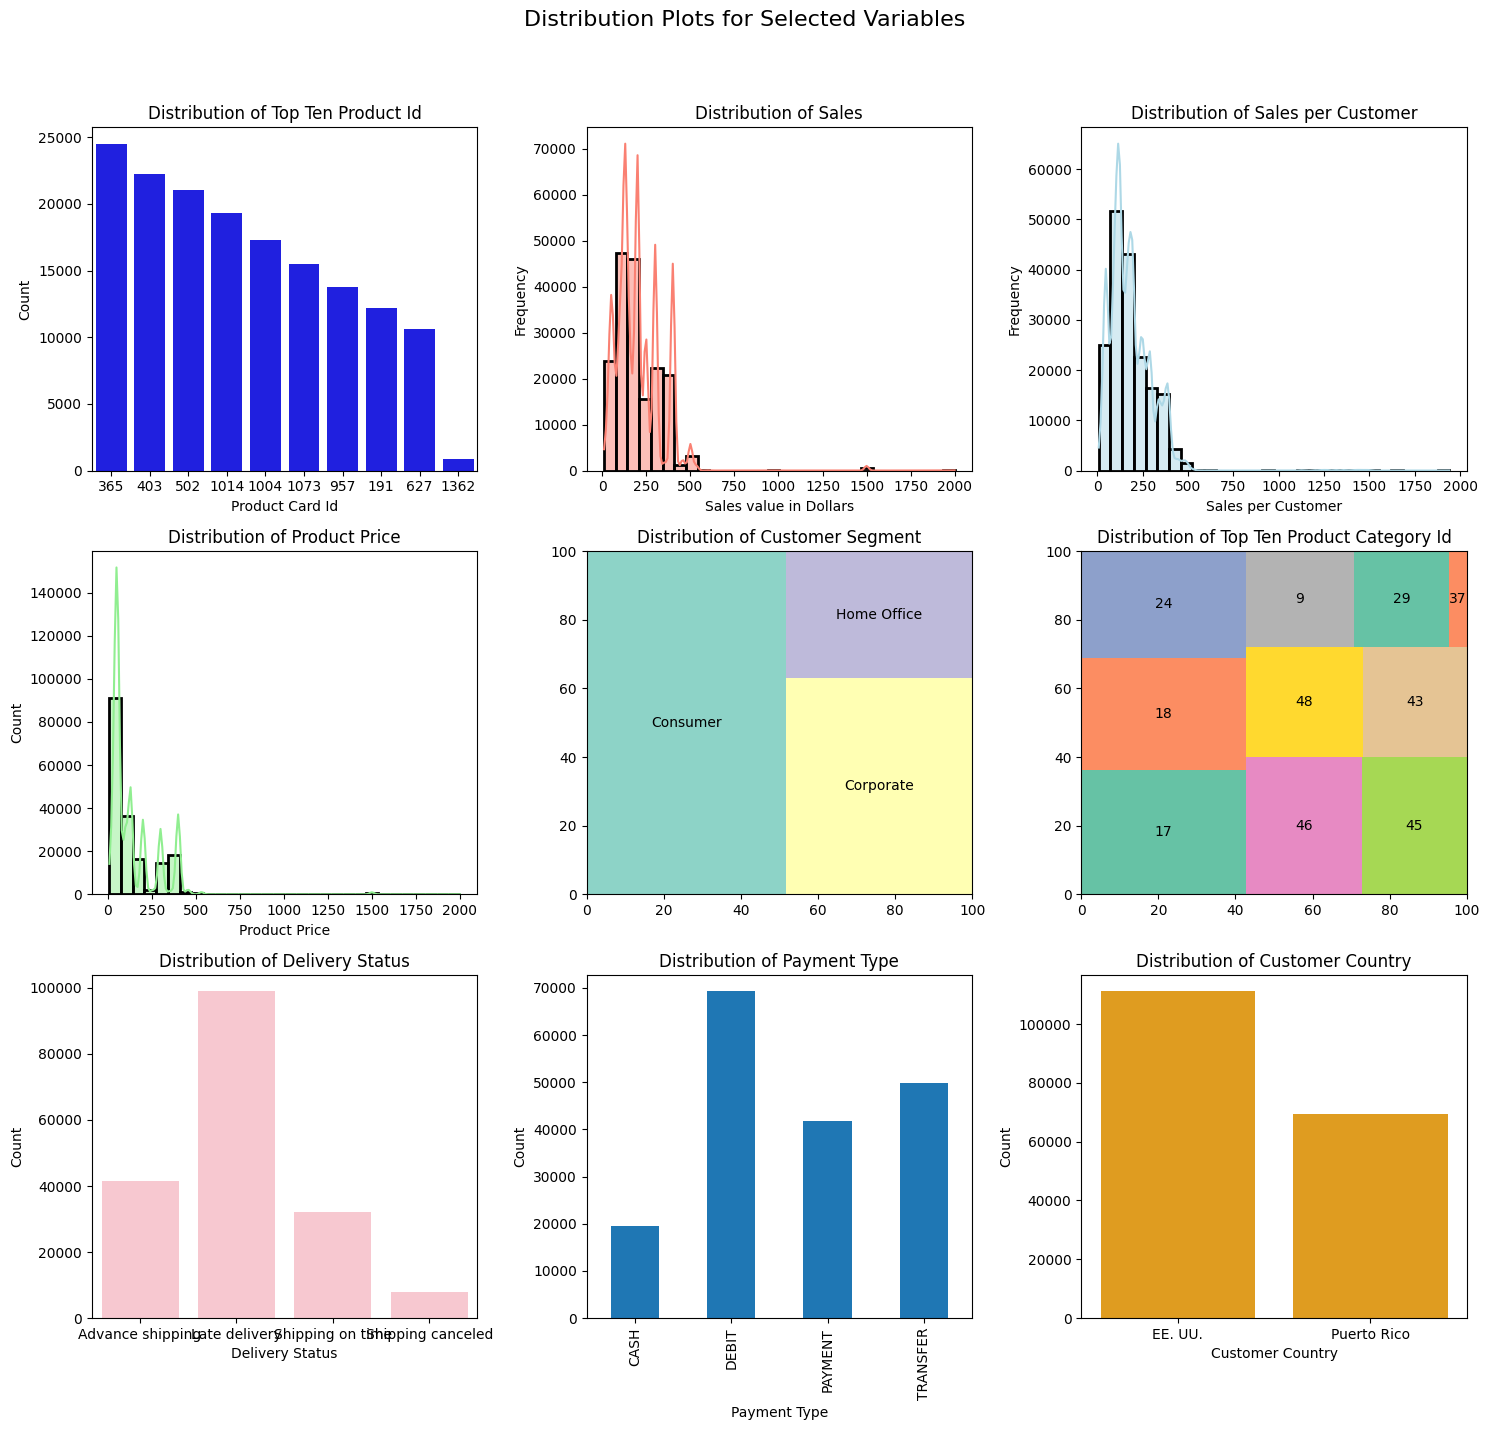

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Distribution Plots for Selected Variables',
             fontsize=16)
df_copy = df.copy()

sns.countplot(data=df_copy, x='Product Card Id',
                color='blue', ax=axes[0, 0],
                order=df_copy['Product Card Id'].value_counts().iloc[:10].index)
axes[0, 0].set_title('Distribution of Top Ten Product Id')
axes[0, 0].set_xlabel('Product Card Id')
axes[0, 0].set_ylabel('Count')

sns.histplot(data=df_copy, x='Sales',
             kde=True, color='salmon',
             bins=30, linewidth=2,
             ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Sales')
axes[0, 1].set_xlabel('Sales value in Dollars')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(data=df_copy, x='Sales per customer',
             bins=30, kde=True, linewidth=2,
             color='lightblue', ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Sales per Customer')
axes[0, 2].set_xlabel('Sales per Customer')
axes[0, 2].set_ylabel('Frequency')

sns.histplot(data=df_copy, x='Product Price', bins=30, kde=True,
             color='lightgreen', linewidth=2, ax=axes[1, 0])

axes[1, 0].set_title('Distribution of Product Price')
axes[1, 0].set_xlabel('Product Price')

squarify.plot(sizes=df_copy['Customer Segment'].value_counts(),
              label=df_copy['Customer Segment'].value_counts().index,
              color=sns.color_palette("Set3"), ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Customer Segment')

squarify.plot(sizes=df_copy['Product Category Id'].value_counts().iloc[:10],
                label=df_copy['Product Category Id'].value_counts().iloc[:10].index,
                color=sns.color_palette("Set2"), ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Top Ten Product Category Id')

sns.countplot(data=df_copy, x='Delivery Status',
                color='pink', ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Delivery Status')
axes[2, 0].set_xlabel('Delivery Status')
axes[2, 0].set_ylabel('Count')

df_copy.groupby(['Type'])['Type'].count().plot(kind='bar',
                                               stacked=True,
                                               ax=axes[2, 1])

axes[2, 1].set_title('Distribution of Payment Type')
axes[2, 1].set_xlabel('Payment Type')
axes[2, 1].set_ylabel('Count')

sns.countplot(data=df_copy, x='Customer Country',
                color='orange', ax=axes[2, 2],
                order=df_copy['Customer Country'].value_counts().iloc[:10].index)
axes[2, 2].set_title('Distribution of Customer Country')
axes[2, 2].set_xlabel('Customer Country')
axes[2, 2].set_ylabel('Count')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



exploratory time series visualization

/tmp/ipython-input-58-1502997007.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_df = df_heatmap.resample('M').sum()


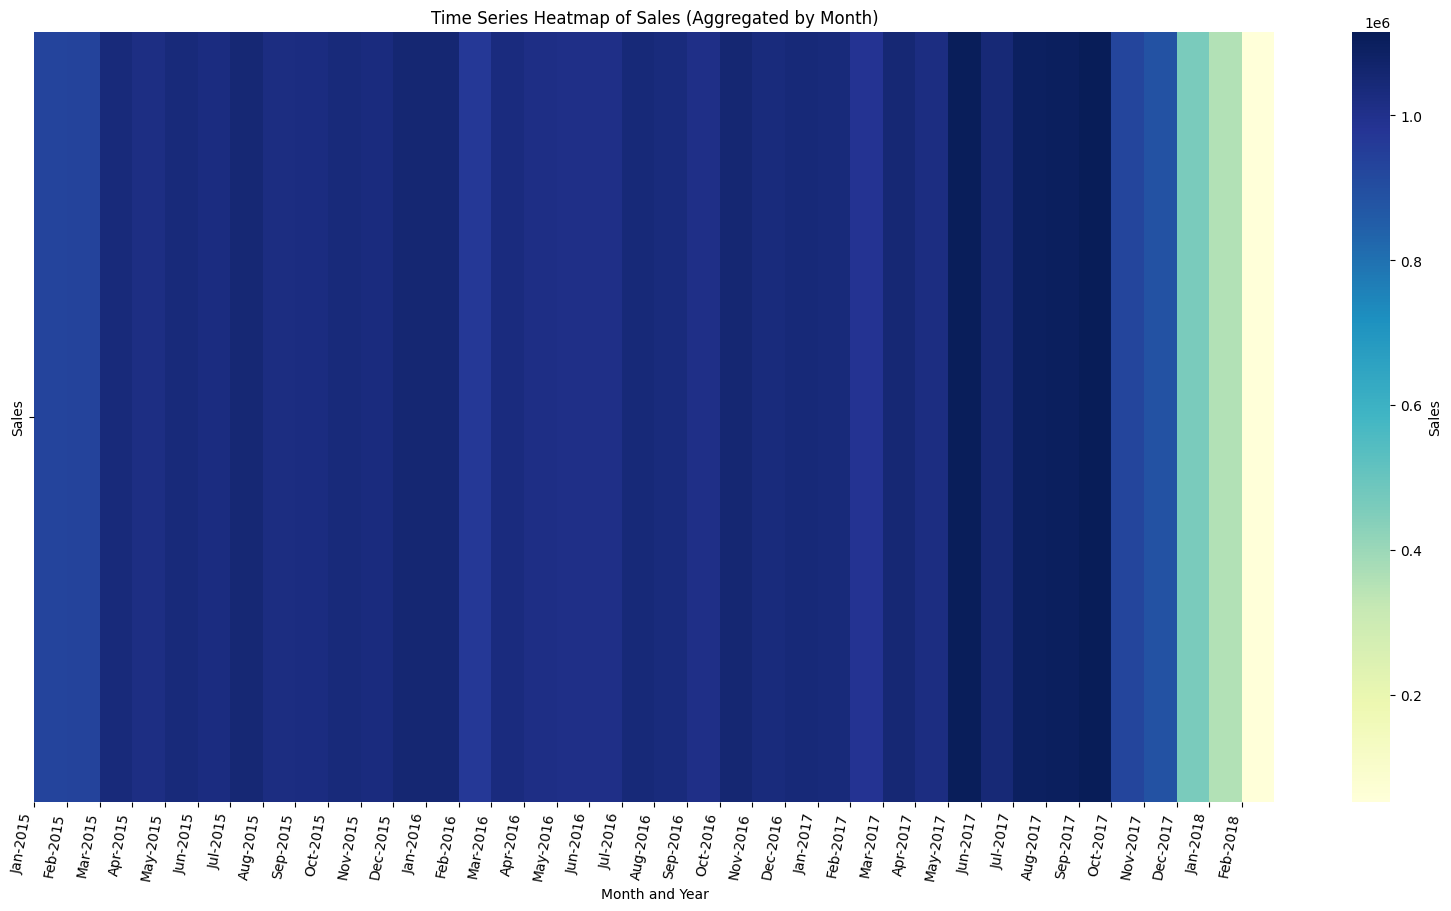

In [ ]:
df_heatmap = df[['shipping date (DateOrders)', 'Sales']]
df_heatmap.set_index('shipping date (DateOrders)', inplace=True)
resampled_df = df_heatmap.resample('M').sum()
month_labels = [calendar.month_abbr[m.month] + '-' + str(m.year) for m in resampled_df.index]
plt.figure(figsize=(20, 10))
sns.heatmap(resampled_df.T, cmap='YlGnBu', cbar_kws={'label': 'Sales'})
plt.xticks(ticks=range(len(month_labels)), labels=month_labels, rotation=80, ha='right')
plt.title('Time Series Heatmap of Sales (Aggregated by Month)')
plt.xlabel('Month and Year')
plt.show()



# model training

In [ ]:
prophet_df = df.copy()
prophet_df = prophet_df.rename(columns={'shipping date (DateOrders)': 'ds', 'Sales': 'y'})
holidays_df = pd.read_csv('holidays.csv', encoding='ISO-8859-1')
holidays_df = holidays_df.rename(columns={'Date': 'ds', 'Name': 'holiday'})
holidays_df['lower_window'] = 0
holidays_df['upper_window'] = 1
holidays_df['ds'] = pd.to_datetime(holidays_df['ds'], format='mixed')

prophet = Prophet(holidays=holidays_df)
prophet.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/nf0ab8d_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/i2fyj35i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99733', 'data', 'file=/tmp/tmpyulhr7i8/nf0ab8d_.json', 'init=/tmp/tmpyulhr7i8/i2fyj35i.json', 'output', 'file=/tmp/tmpyulhr7i8/prophet_modelu5foeu2t/prophet_model-20250718160747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:07:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)

evaluating the models

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(model=prophet, initial='730 days', period='365 days', horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2017-02-06 22:14:00 and 2017-02-06 22:14:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/__31mrby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/rya8bzvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97952', 'data', 'file=/tmp/tmpyulhr7i8/__31mrby.json', 'init=/tmp/tmpyulhr7i8/rya8bzvh.json', 'output', 'file=/tmp/tmpyulhr7i8/prophet_model46jvk_du/prophet_model-20250718162024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


<Figure size 900x600 with 0 Axes>

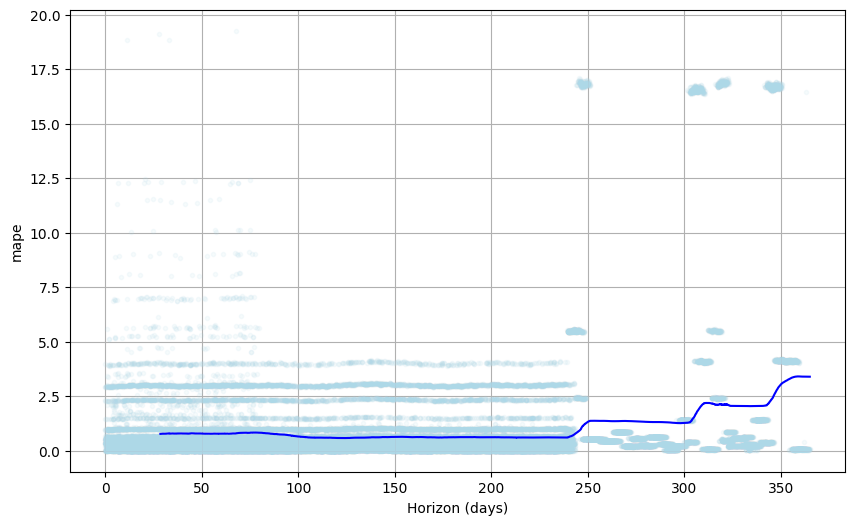

In [ ]:
from prophet.plot import plot_cross_validation_metric
#  set fig size
plt.figure(figsize=(9, 6))
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')
fig.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')

hyper parameters

In [ ]:
tuned_prophet = Prophet(holidays=holidays_df,
                        seasonality_mode='additive',
                        seasonality_prior_scale=1,
                        holidays_prior_scale=5,
                        changepoint_prior_scale=0.005)
tuned_prophet.fit(prophet_df)
future = tuned_prophet.make_future_dataframe(periods=365, freq='D')

new_forecast = tuned_prophet.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/65g5jbu6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/e6800qf2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11827', 'data', 'file=/tmp/tmpyulhr7i8/65g5jbu6.json', 'init=/tmp/tmpyulhr7i8/e6800qf2.json', 'output', 'file=/tmp/tmpyulhr7i8/prophet_model3csg29kl/prophet_model-20250718162215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics
# Perform cross-validation
tuned_df_cv = cross_validation(model=tuned_prophet, initial='730 days', period='365 days', horizon='365 days')

INFO:prophet:Making 1 forecasts with cutoffs between 2017-02-06 22:14:00 and 2017-02-06 22:14:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/_vslg8m_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyulhr7i8/2tnbw4x4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92969', 'data', 'file=/tmp/tmpyulhr7i8/_vslg8m_.json', 'init=/tmp/tmpyulhr7i8/2tnbw4x4.json', 'output', 'file=/tmp/tmpyulhr7i8/prophet_model3i35xflt/prophet_model-20250718162657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:28:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be remov

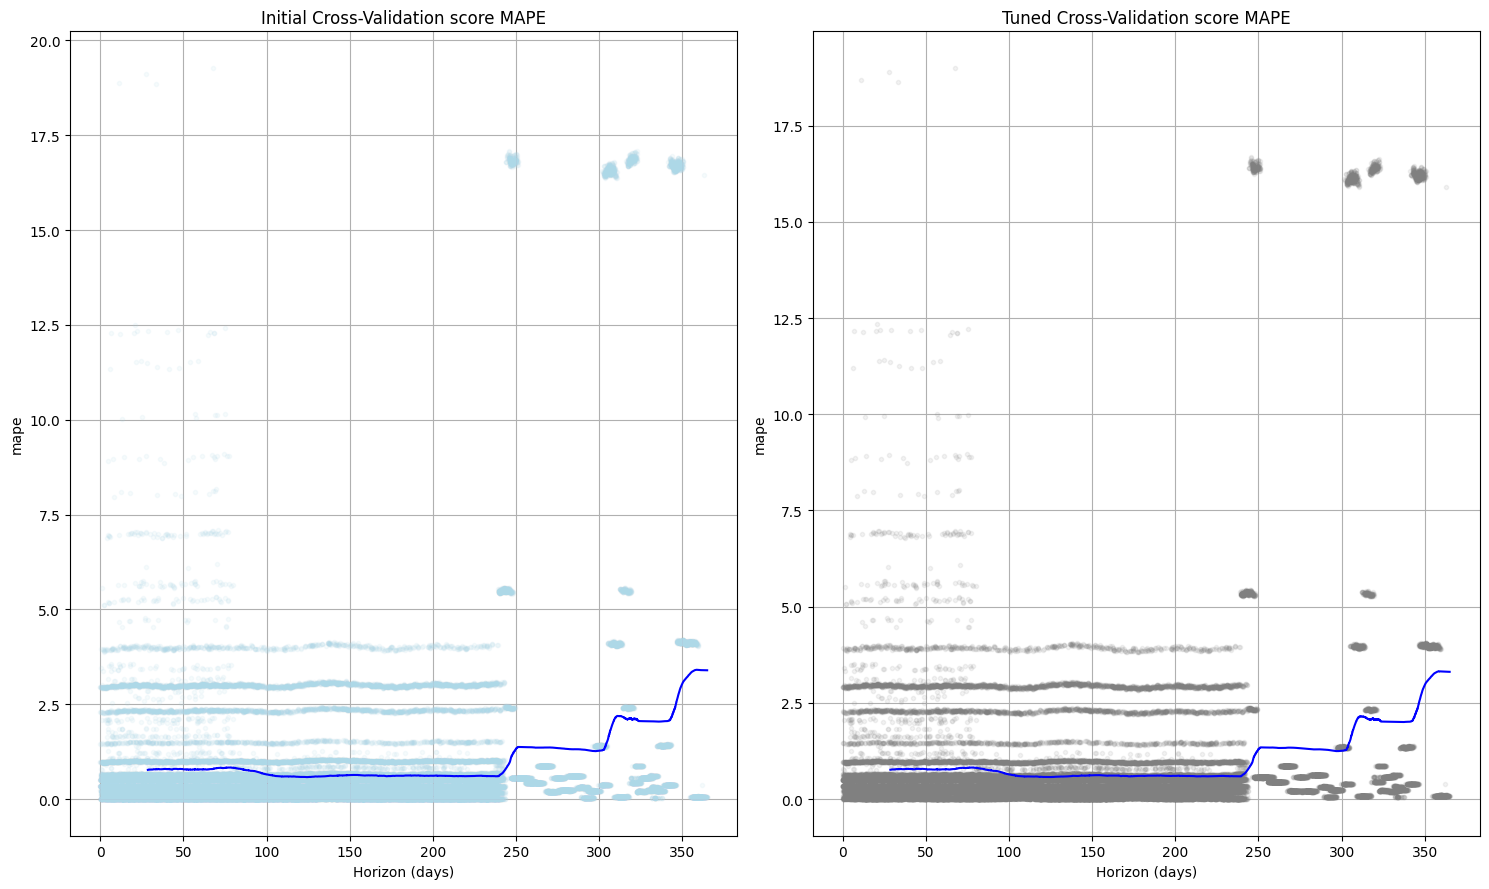

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 9))

fig1 = plot_cross_validation_metric(df_cv, metric='mape', ax=axs[0])
fig1.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')
fig1.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E7')
axs[0].set_title('Initial Cross-Validation score MAPE')

fig2 = plot_cross_validation_metric(tuned_df_cv, metric='mape', ax=axs[1])
fig2.get_axes()[0].get_lines()[0].set_markerfacecolor('#ADD8E7')
fig2.get_axes()[0].get_lines()[0].set_markeredgecolor('#ADD8E9')
axs[1].set_title('Tuned Cross-Validation score MAPE')

plt.tight_layout()
plt.show()

visualizing forecasted sales

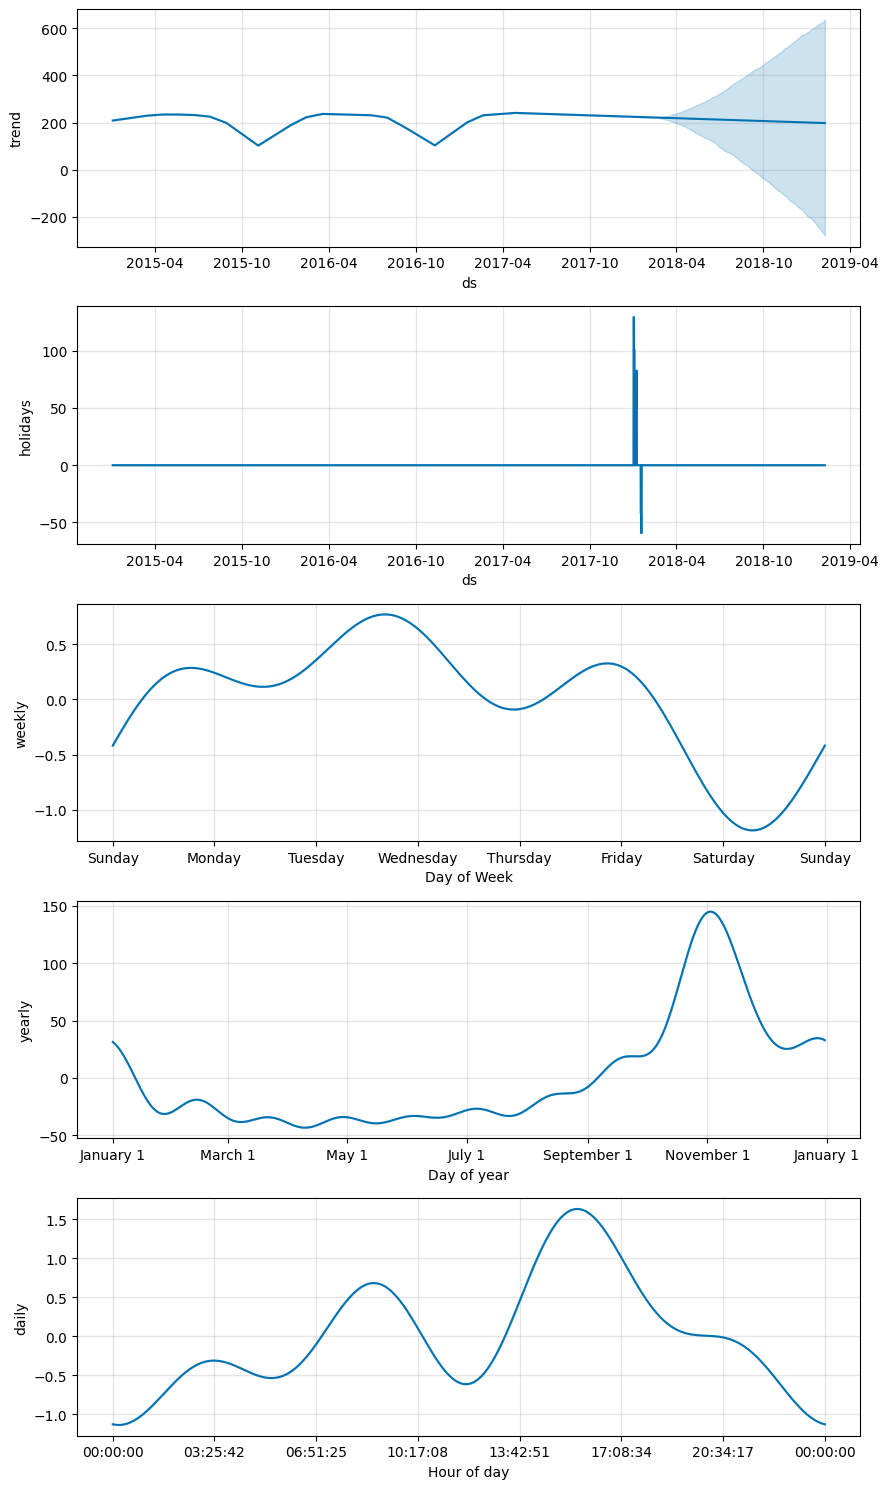

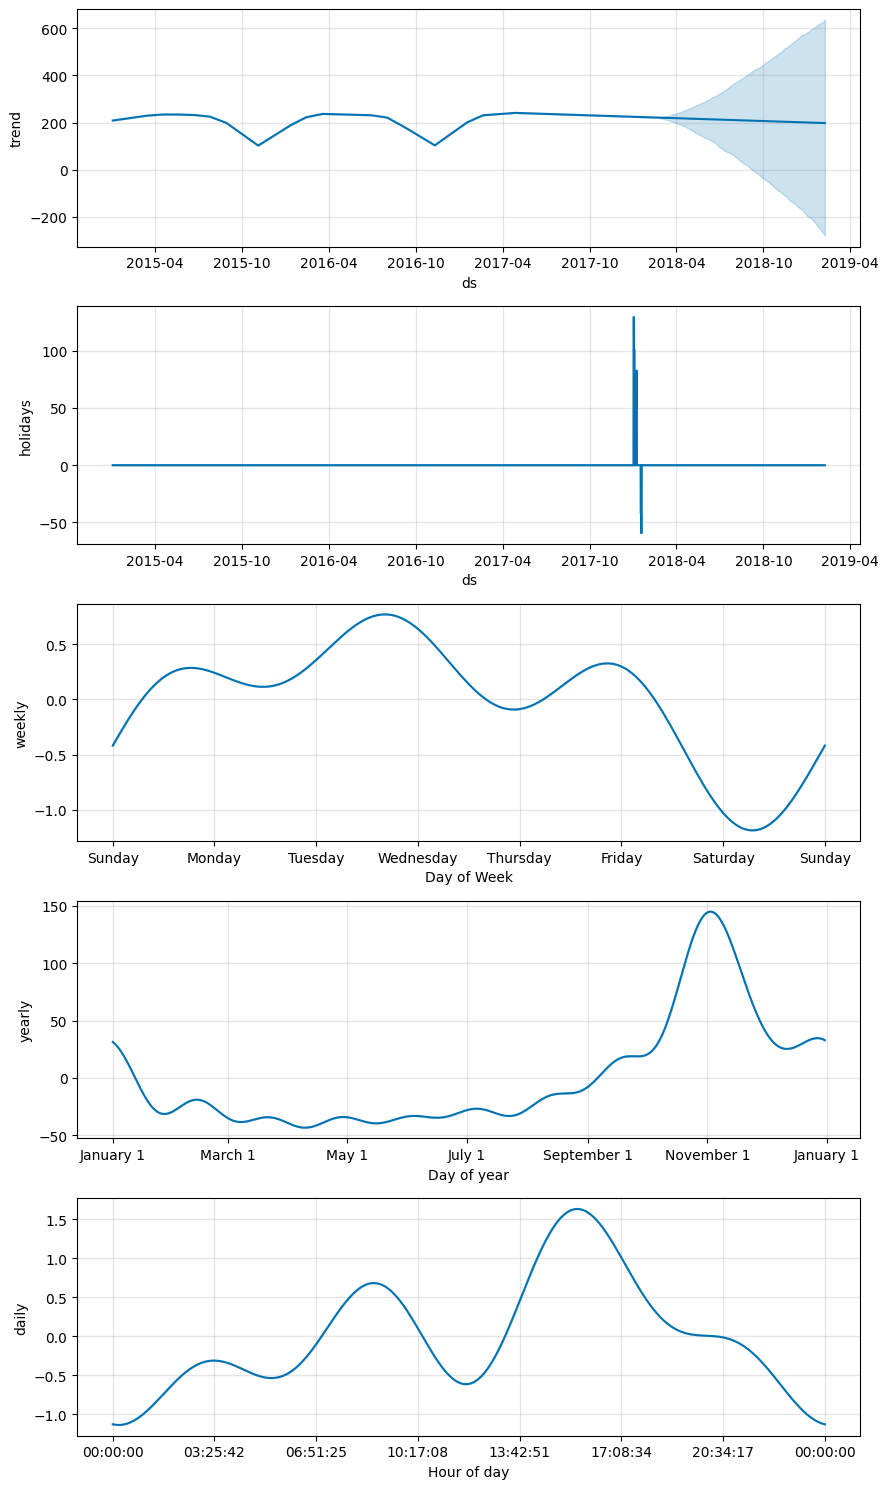

In [ ]:
tuned_prophet.plot_components(new_forecast)

# finding optimal invemtory policy

In [ ]:
average_forecasted_sales = new_forecast['yhat'].mean()
average_lead_time = 7
lead_time_demand = average_forecasted_sales * average_lead_time


np.float64(1469.5360249437804)

In [ ]:
max_daily_forecasted_sales = new_forecast['yhat'].max()
max_lead_time = 10
safety_stock = (max_daily_forecasted_sales * max_lead_time) - lead_time_demand
safety_stock

np.float64(2397.516104483553)

In [ ]:
reorder_point = lead_time_demand + safety_stock
int(reorder_point)

3867

In [ ]:
product_price = df[df['Product Card Id'] == 365]['Product Price'].iloc[0]
H = 0.10 * product_price
S = 0.30 * product_price
D = new_forecast['yhat'].mean()
EOQ = math.sqrt((2 * D * S) / H)
EOQ

35.49087639231622